In [1]:
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy

# from imitation.algorithms.adversarial.airl import AIRL
from IRL_lib_mod.airl import AIRL
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.policies.serialize import load_policy
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from utils.irl_utils import make_vec_env_robosuite
from utils.demostration_utils import load_dataset_to_trajectories
import os
import h5py
import json
from robosuite.controllers import load_controller_config
from utils.demostration_utils import load_dataset_and_annotations_simutanously
from utils.annotation_utils import read_all_json
from imitation.util import logger as imit_logger
import imitation.scripts.train_adversarial as train_adversarial
import argparse
import robosuite as suite
import torch
from utils.demostration_utils import load_data_to_h5py
from utils.annotation_utils import write_to_json
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

2024-08-22 13:06:23.600755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 13:06:23.997842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 13:06:24.108550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 13:06:24.889792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 13:06:27.433619: W tensorflow/compiler/tf2

In [2]:


notebook_path = os.getcwd()  # Get current working directory (where the notebook is running)
notebook_path = os.path.abspath(notebook_path)  # Get absolute path of the notebook
#- "experiments"
project_path = notebook_path.split("experiments")[0]
print(project_path)
dataset_path = os.path.join(project_path, "human-demo/can-pick/low_dim_v141.hdf5")

# Now, proceed with your h5py file operations
f = h5py.File(dataset_path, 'r')
env_meta = json.loads(f["data"].attrs["env_args"])

/home/hang/AIRL_with_Progress/learning-with-progress_shijie/


In [3]:
make_env_kwargs = dict(
    robots="Panda",             # load a Sawyer robot and a Panda robot
    gripper_types="default",                # use default grippers per robot arm
    controller_configs=env_meta["env_kwargs"]["controller_configs"],   # each arm is controlled using OSC
    has_renderer=True,                      # on-screen rendering
    render_camera="frontview",              # visualize the "frontview" camera
    has_offscreen_renderer=True,           # no off-screen rendering
    control_freq=20,                        # 20 hz control for applied actions
    horizon=1000,                            # each episode terminates after 200 steps
    use_object_obs=True,                   # no observations needed
    use_camera_obs=False,
    reward_shaping=True,
)

SEED = 42

env = suite.make(
    "PickPlaceCanModified",
    **make_env_kwargs,
)

In [4]:

exp_name = "no_shaping"
#exp_name = "with_value_shaping"
checkpoint = "340"
policy = PPO.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/gen_policy/model")
reward_net = (torch.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/reward_train.pt"))
reward_net.eval()
reward_net_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_net.to(reward_net_device)

evaluate_times = 10
obs_keys = ["object-state", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
replay_demo_keys = [
    'demo_0', 'demo_1', 'demo_100', 'demo_101', 'demo_102',

]
    # 'demo_107', 'demo_124', 'demo_14', 'demo_143', 'demo_160', 'demo_166',
    # 'demo_17', 'demo_187', 'demo_199'

print(replay_demo_keys)
# set json data folder
data_folder = "progress_data_mh"
# indexing with demo keys


['demo_0', 'demo_1', 'demo_100', 'demo_101', 'demo_102']


/tmp/ipykernel_3985/2080141740.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_net = (torch.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/reward_train

In [5]:


rewards_no_shaping = { key: [] for key in replay_demo_keys}
values_no_shaping = { key: [] for key in replay_demo_keys}
reward_no_shaping = { key: [] for key in replay_demo_keys}
gripper_close = { key: 0 for key in replay_demo_keys}
for key in replay_demo_keys:
    print("replaying {}: ", key)
    obs = np.array(f["data/{}/obs".format(key)])
    actions = np.array(f["data/{}/actions".format(key)])
    # print(actions)
    dones = np.array(f["data/{}/dones".format(key)])
    # set initial state
    initial_state = f["data/{}/states".format(key)][0]
    
    obs = env.reset()
    env.sim.set_state_from_flattened(initial_state)
    env.sim.forward()
    #env.render()
    reward = 0
    obs,_,_,_ = env.step(np.zeros(7))
    obs = [obs[key] for key in obs_keys]
    obs = np.concatenate(obs)
    past_action = np.zeros(7)
    done = False
    cnt = 0
    for action in actions:
        # print(action)
        next_obs, reward, next_done, info = env.step(action)
        if action[6] == 1 and past_action[6] == -1:
            gripper_close[key] = cnt
        next_obs = [next_obs[key] for key in obs_keys]
        next_obs = np.concatenate(next_obs)
        # print(next_obs)
        
        obs_tensor = torch.tensor(obs).float().unsqueeze(0).to(reward_net_device)
        action_tensor = torch.tensor(action).float().unsqueeze(0).to(reward_net_device)
        next_obs_tensor = torch.tensor(next_obs).float().unsqueeze(0).to(reward_net_device)
        done = torch.tensor([0]).float().unsqueeze(0).to(reward_net_device)
        # get the reward from the reward network
        disc_rew = reward_net(obs_tensor, action_tensor, next_obs_tensor, done)
        rew = reward_net.base(obs_tensor, action_tensor, next_obs_tensor, done)
        value = reward_net.potential(obs_tensor)
        # append reward to rewards
        rewards_no_shaping[key].append(disc_rew.item())
        reward_no_shaping[key].append(rew.item())
        values_no_shaping[key].append(value.item())
        obs = next_obs
        past_action = action
        #print(f"Discriminator Reward: {disc_rew}")
        cnt += 1
        #env.render()
        if next_done:
            break
env.close()




replaying {}:  demo_0
replaying {}:  demo_1
replaying {}:  demo_100
replaying {}:  demo_101
replaying {}:  demo_102


In [6]:

exp_name = "ph_try_out"
#exp_name = "with_value_shaping"
checkpoint = "600"
policy = PPO.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/gen_policy/model")
reward_net = (torch.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/reward_train.pt"))
reward_net.eval()
reward_net_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_net.to(reward_net_device)

evaluate_times = 10
obs_keys = ["object-state", "robot0_eef_pos", "robot0_eef_quat", "robot0_gripper_qpos"]
# 'demo_100', 'demo_101', 'demo_102',
#     'demo_107', 'demo_124', 'demo_14', 'demo_143', 'demo_160', 'demo_166',
#     'demo_17', 'demo_187', 'demo_199'
print(replay_demo_keys)
# set json data folder
data_folder = "progress_data_mh"
# indexing with demo keys


['demo_0', 'demo_1', 'demo_100', 'demo_101', 'demo_102']


/tmp/ipykernel_3985/974307454.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_net = (torch.load(f"{project_path}/checkpoints/{exp_name}/{checkpoint}/reward_train.

In [7]:
                                    

rewards_with_value_shaping = { key: [] for key in replay_demo_keys}
value_with_shaping = { key: [] for key in replay_demo_keys}
rewards_with_shaping = { key: [] for key in replay_demo_keys}
gripper_close = { key: 0 for key in replay_demo_keys}
for key in replay_demo_keys:
    print("replaying {}: ", key)
    obs = np.array(f["data/{}/obs".format(key)])
    actions = np.array(f["data/{}/actions".format(key)])
    # print(actions)
    dones = np.array(f["data/{}/dones".format(key)])
    # set initial state
    initial_state = f["data/{}/states".format(key)][0]
    
    obs = env.reset()
    env.sim.set_state_from_flattened(initial_state)
    env.sim.forward()
    #env.render()
    reward = 0
    obs,_,_,_ = env.step(np.zeros(7))
    obs = [obs[key] for key in obs_keys]
    obs = np.concatenate(obs)
    past_action = np.zeros(7)
    done = False
    cnt = 0
    for action in actions:
        # print(action)
        next_obs, reward, next_done, info = env.step(action)
        if action[6] == 1 and past_action[6] == -1:
            gripper_close[key] = cnt
        next_obs = [next_obs[key] for key in obs_keys]
        next_obs = np.concatenate(next_obs)
        # print(next_obs)
        
        obs_tensor = torch.tensor(obs).float().unsqueeze(0).to(reward_net_device)
        action_tensor = torch.tensor(action).float().unsqueeze(0).to(reward_net_device)
        next_obs_tensor = torch.tensor(next_obs).float().unsqueeze(0).to(reward_net_device)
        done = torch.tensor([0]).float().unsqueeze(0).to(reward_net_device)
        # get the reward from the reward network
        disc_rew = reward_net(obs_tensor, action_tensor, next_obs_tensor, done)
        rew = reward_net.base(obs_tensor, action_tensor, next_obs_tensor, done)
        value = reward_net.potential(obs_tensor)
        # append reward to rewards
        rewards_with_value_shaping[key].append(disc_rew.item())
        value_with_shaping[key].append(value.item())
        rewards_with_shaping[key].append(rew.item())
        obs = next_obs
        past_action = action
        #print(f"Discriminator Reward: {disc_rew}")
        cnt += 1
        #env.render()
        if next_done:
            break
env.close()




replaying {}:  demo_0
replaying {}:  demo_1
replaying {}:  demo_100
replaying {}:  demo_101
replaying {}:  demo_102


{'demo_0': [102773.375, 102038.09375, 99322.015625, 94965.9296875, 90842.875, 87636.953125, 85437.2734375, 84108.7265625, 83175.2578125, 82452.59375, 81602.671875, 80703.265625, 79637.078125, 78359.234375, 76931.734375, 75355.15625, 73932.1171875, 72451.5703125, 70907.453125, 69460.3984375, 68111.125, 66831.9921875, 65529.3828125, 64310.265625, 63278.6796875, 62482.6484375, 61665.81640625, 59000.96484375, 57958.9765625, 57064.484375, 56267.4296875, 55688.2734375, 55328.3984375, 55028.6484375, 54799.046875, 54655.390625, 54398.484375, 54120.0390625, 53744.23828125, 53337.9375, 52963.46875, 52732.79296875, 52494.3046875, 52416.03515625, 52275.28515625, 52166.0, 52027.921875, 51911.91015625, 51826.9453125, 51769.1328125, 51704.5234375, 51521.80078125, 51313.5390625, 51245.765625, 51640.8359375, 55683.55078125, 54440.828125, 58423.921875, 58797.82421875, 59023.89453125, 58830.3359375, 58200.3125, 56774.6875, 54903.58984375, 52653.65234375, 50301.6875, 48132.80859375, 46337.83984375, 44762.

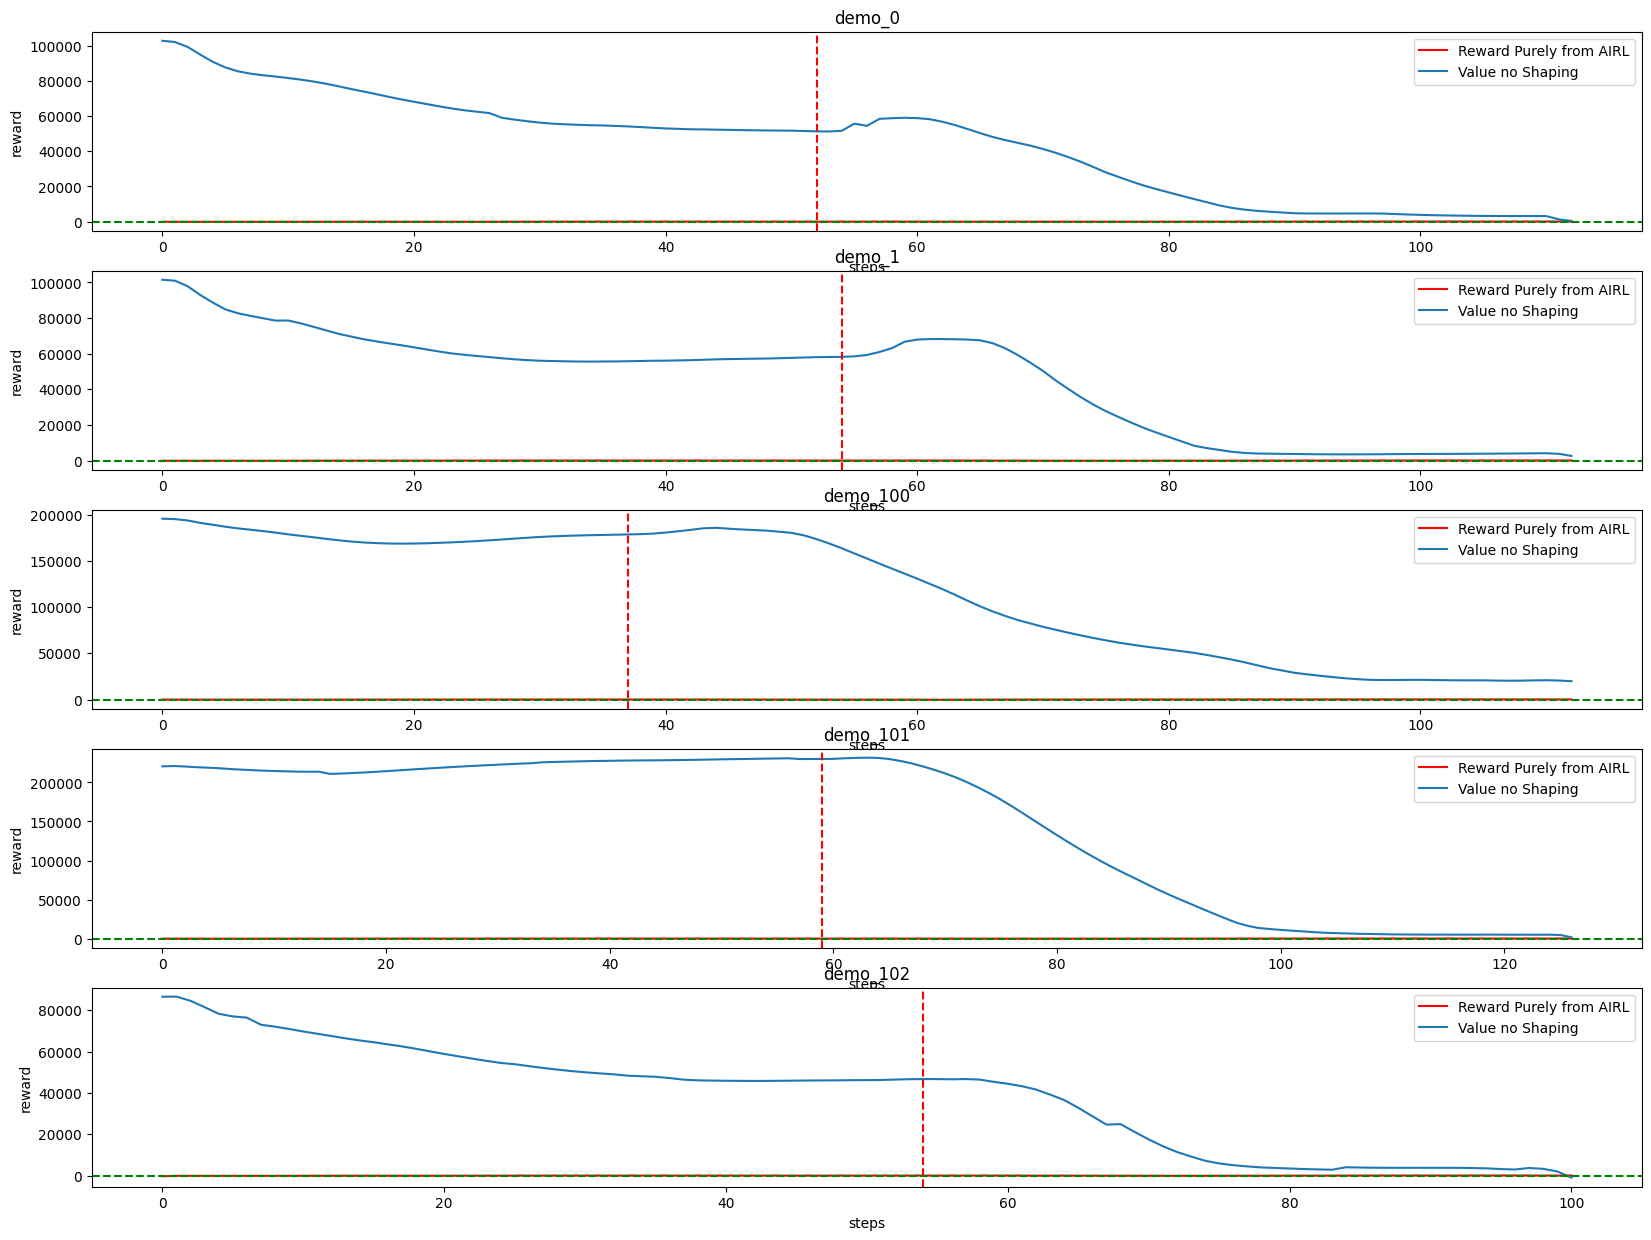

In [10]:
#plot rewards for each demo
print(value_with_shaping)
print(rewards_with_shaping)
fig, ax = plt.subplots(len(replay_demo_keys), 1, figsize=(20, 3* len(replay_demo_keys)))
for i, key in enumerate(replay_demo_keys):
    sns.lineplot(x=range(len(rewards_no_shaping[key])), y=rewards_no_shaping[key], ax=ax[i], label="Reward Purely from AIRL", color = "red")
    sns.lineplot(x=range(len(values_no_shaping[key])), y=value_with_shaping[key], ax=ax[i], label="Value no Shaping")
    #sns.lineplot(x=range(len(reward_no_shaping[key])), y=rewards_with_shaping[key], ax=ax[i], label="Reward no Shaping", color = "green")
    #sns.lineplot(x=range(len(value_with_shaping[key])), y=value_with_shaping[key], ax=ax[i], label="Value with Shaping", color = "blue")
    # sns.lineplot(x=range(len(rewards_with_shaping[key])), y=rewards_with_shaping[key], ax=ax[i], label="Reward with Shaping", color = "green")
    # sns.lineplot(x=range(len(rewards_with_value_shaping[key])), y=rewards_with_value_shaping[key], ax=ax[i], label="DPHIRL", color = "black")

    #plot a vertical line where the gripper is closed
    ax[i].axvline(gripper_close[key], color='r', linestyle = '--')
    #a horizontal line for the reward
    ax[i].axhline(0, color='g', linestyle = '--')
    ax[i].set_title(key)
    ax[i].set_xlabel("steps")
    ax[i].set_ylabel("reward")
    ax[i].legend()
plt.show()

